# ==============================================================================
# Author: Rushikesh Chopade
# Project: AI-Based Neighborhood Finder using KMeans Clustering
# Description: Clustering residential neighborhoods using structured data to 
#              assist in recommendation systems. 
# ==============================================================================


Initial Dataset Shape: (656, 17)
Dataset Preview:


,Neighborhood,Sublocality,City,Property Type,Price (INR),Area (sq ft),Bedrooms,Price per sq ft,Monthly Rent (INR),Schools Nearby,Hospitals Nearby,Public Transport,Amenities,Community Sentiment,Crime Rate,Professions,General Income (INR)
0,Koregaon Park,North Main Road,Pune,Apartment,18500000,1600,3,11563,50000,8,7,Very High,Gym,Very High,Low,"(Investment Banker, Entrepreneur, Senior Execu...",200000-800000
1,Baner,Baner Road,Pune,Apartment,14500000,1400,3,10357,38000,7,6,High,Clubhouse,High,Low,"(Software Engineer, Consultant, IT Director)",150000-500000
2,Balewadi,Balewadi High Street,Pune,Penthouse,16500000,2400,4,6875,85000,9,7,Very High,Swimming Pool,Very High,Low,"(Startup Founder, Senior Executive, Investor)",300000+
3,Aundh,DP Road,Pune,Apartment,13500000,1500,3,9000,40000,7,6,High,Gated Security,High,Low,"(Doctor, Lawyer, Business Owner)",120000-400000
4,Aundh,Westend Colony,Pune,Apartment,13800000,1550,3,8900,42000,8,6,High,Clubhouse,High,Low,"(Bank Manager, Consultant, Architect)",120000-350000


Dataset Shape After Cleaning: (287, 17)


c:\Users\rushi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\rushi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\rushi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\rushi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

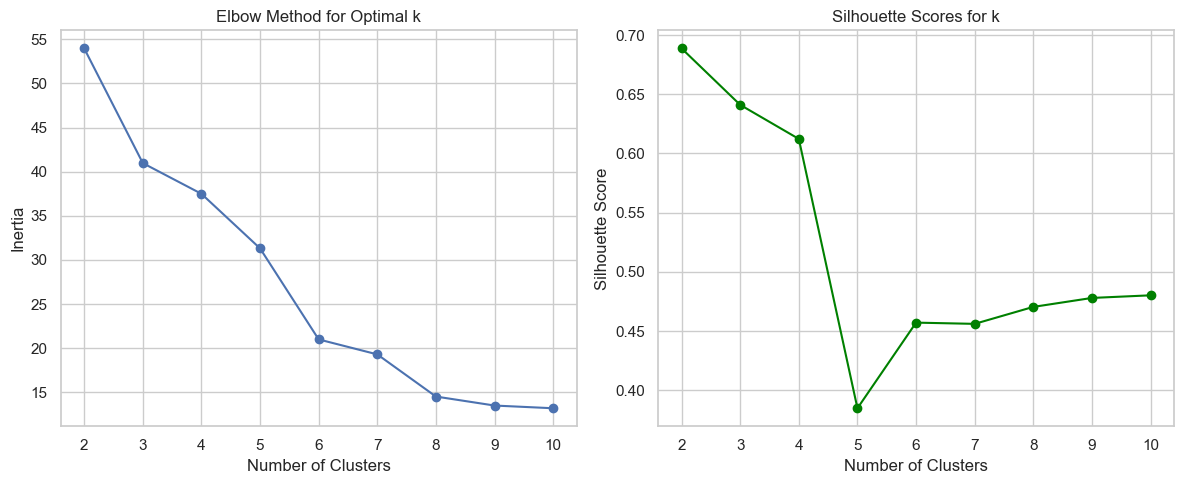

c:\Users\rushi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


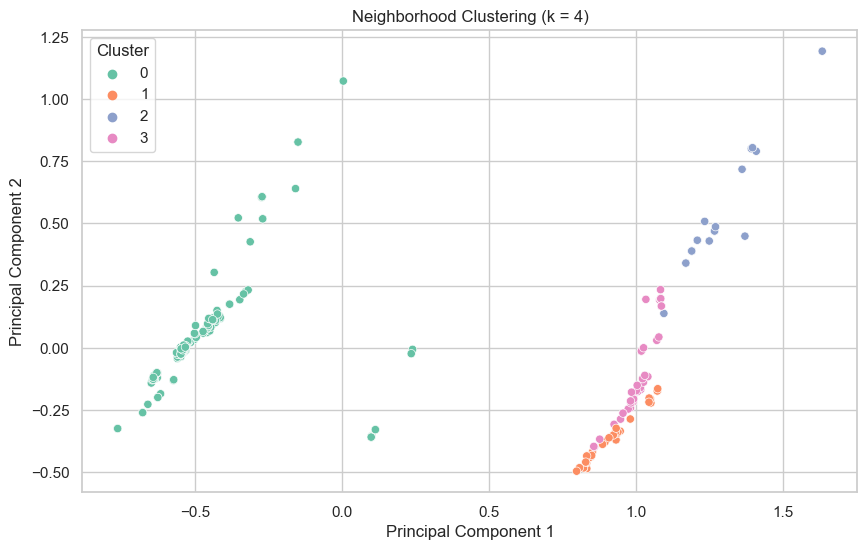

Cluster Feature Summary:


,Price (INR),Area (sq ft),Bedrooms,Price per sq ft,Monthly Rent (INR),Schools Nearby,Hospitals Nearby,General Income (INR),Public Transport,Community Sentiment,Crime Rate
Cluster,,,,,,,,,,,
0,0.103801,0.060700,0.258883,0.445771,0.097621,0.376481,0.365482,0.121726,0.055838,0.0,0.0
1,0.201810,0.060892,0.250000,0.687485,0.185250,0.632353,0.617647,0.299160,1.000000,1.0,0.0
2,0.605128,0.572656,0.762500,0.392009,0.578731,0.841667,0.783333,0.462857,1.000000,1.0,0.0
3,0.197934,0.274957,0.375000,0.231722,0.224710,0.754630,0.643519,0.326032,1.000000,1.0,0.0



Cluster Size Distribution:
Cluster
0    197
3     36
1     34
2     20
Name: count, dtype: int64
Clustered data saved to 'kmeans_clustered_neighborhoods.csv'


In [1]:

# ==============================
# 1. Import Required Libraries
# ==============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

# =========================
# 2. Load and Inspect Data
# =========================

df = pd.read_csv("pd copy.csv")

print("Initial Dataset Shape:", df.shape)
print("Dataset Preview:")
display(df.head())

# ====================================
# 3. Feature Engineering and Cleaning
# ====================================

# Convert income ranges to numeric values
def parse_income(value):
    if pd.isnull(value):
        return np.nan
    if '+' in value:
        return int(value.replace('+', '').strip())
    elif '-' in value:
        low, high = map(int, value.split('-'))
        return (low + high) // 2
    return np.nan

df['General Income (INR)'] = df['General Income (INR)'].apply(parse_income)

# Map ordinal categorical values
ordinal_encodings = {
    'Public Transport': {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'Community Sentiment': {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'Crime Rate': {'High': 1, 'Medium': 2, 'Low': 3}
}

for column, mapping in ordinal_encodings.items():
    df[column] = df[column].map(mapping)

# Define the final feature set for clustering
selected_features = [
    'Price (INR)', 'Area (sq ft)', 'Bedrooms', 'Price per sq ft',
    'Monthly Rent (INR)', 'Schools Nearby', 'Hospitals Nearby',
    'General Income (INR)', 'Public Transport',
    'Community Sentiment', 'Crime Rate'
]

# Drop rows with missing values in selected features
df_cleaned = df.dropna(subset=selected_features)
print("Dataset Shape After Cleaning:", df_cleaned.shape)

# ========================
# 4. Feature Normalization
# ========================

scaler = MinMaxScaler()
df_scaled = df_cleaned.copy()
df_scaled[selected_features] = scaler.fit_transform(df_cleaned[selected_features])

# ============================================================
# 5. Optimal K Selection using Elbow and Silhouette Analysis
# ============================================================

inertia_values = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled[selected_features])
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled[selected_features], labels))

# Plot Elbow and Silhouette Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Scores for k")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# ===================================
# 6. Final KMeans Clustering with k=4
# ===================================

# You can choose optimal_k based on the plots above
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['Cluster'] = kmeans_final.fit_predict(df_scaled[selected_features])

# ============================
# 7. PCA for Data Visualization
# ============================

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled[selected_features])
df_scaled['PCA1'] = pca_result[:, 0]
df_scaled['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scaled, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title(f'Neighborhood Clustering (k = {optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# =====================
# 8. Cluster Evaluation
# =====================

cluster_summary = df_scaled.groupby('Cluster')[selected_features].mean()
cluster_counts = df_scaled['Cluster'].value_counts()

print("Cluster Feature Summary:")
display(cluster_summary)

print("\nCluster Size Distribution:")
print(cluster_counts)

# =============================
# 9. Export Clustered Dataset
# =============================

df_scaled.to_csv("kmeans_clustered_neighborhoods.csv", index=False)
print("Clustered data saved to 'kmeans_clustered_neighborhoods.csv'")